Importing necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import json
import requests
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

In [2]:
data = pd.read_csv("data/kc_house_data.csv")

In [3]:
df = pd.DataFrame(data)

In [4]:
len(df.columns)

21

In [5]:
len(df)

21597

In [6]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Investigating the data we can see high standard deviations for the square foot living space, square foot lot.  Mean price is 540296 with a std deviation of 367368 and a max value of 7.7 million.

In [7]:
df.drop_duplicates() #checking for duplicates, none found

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


Investigating placeholder and nan values

In [8]:
col_list = list(df.columns)
for col in col_list:
    print(df[col].value_counts())

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64
6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
5/24/2015      1
8/3/2014       1
7/27/2014      1
1/31/2015      1
2/15/2015      1
Name: date, Length: 372, dtype: int64
350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.

In [9]:
df = df[df["sqft_basement"] != '?']

In [10]:
df["sqft_basement"] = df["sqft_basement"].astype(float)

In [11]:
df["date"] = df["date"].map(lambda date: datetime.strptime(date, '%m/%d/%Y'))

In [12]:
df['date']=df['date'].map(datetime.toordinal)

In [13]:
df["waterfront"] = df["waterfront"].astype(str)

In [14]:
df.drop(columns = "view", inplace = True)

Investigating distribution of variables

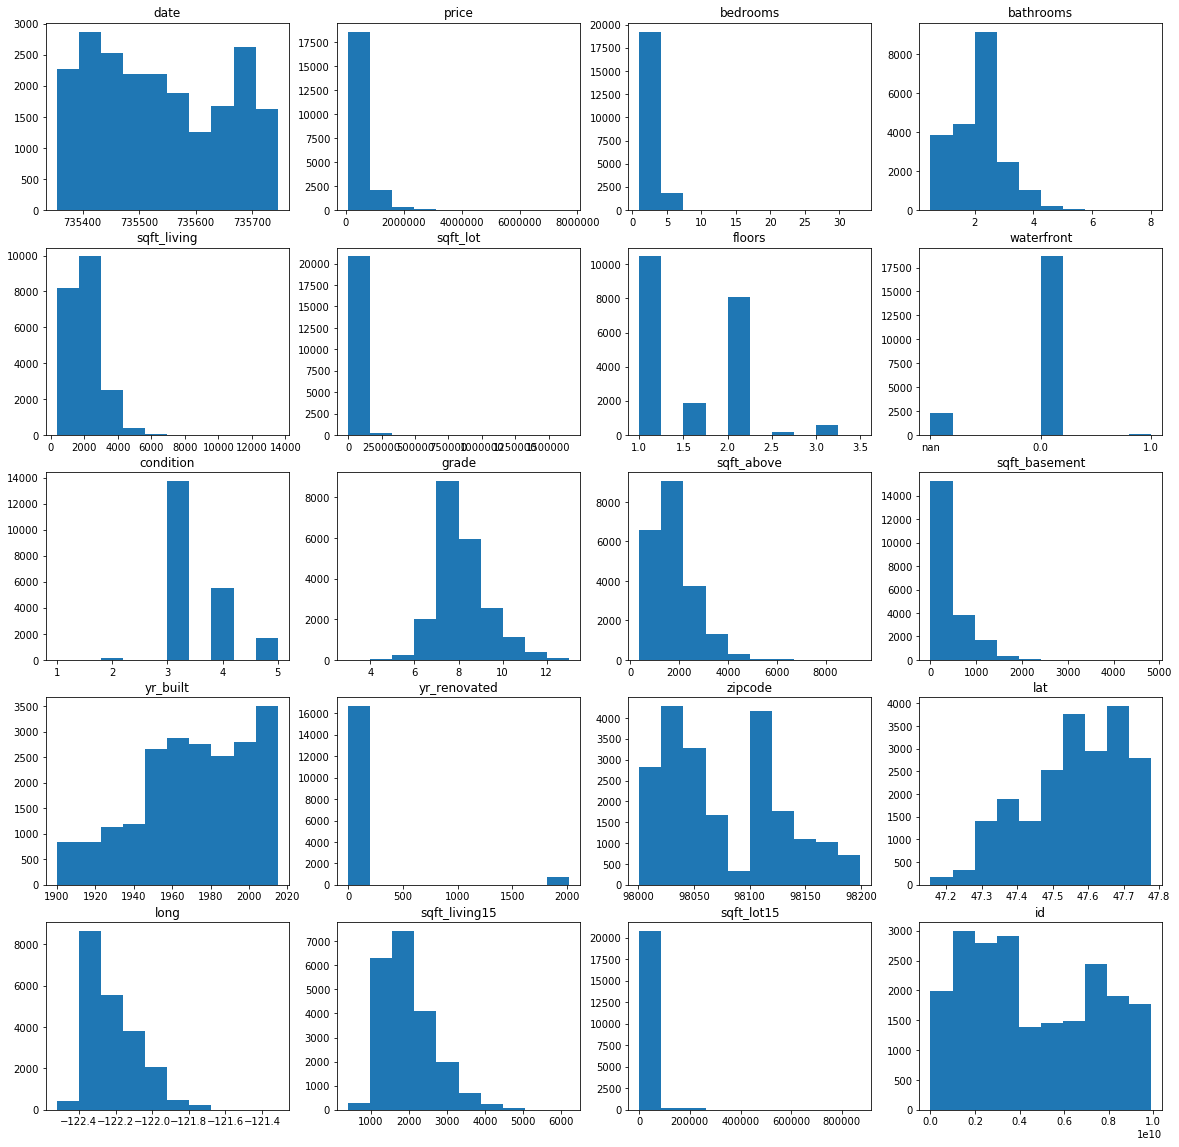

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(20,20))
plt.title('Graphs')
x = df.price
for n in range(len(df.columns)):
    row=(n-1)//4
    col=n%4-1
    ax=axes[row][col]
    y=df.iloc[:,n]
    ax.hist(y)
    ax.set_title(df.columns.values[n])
plt.show()   

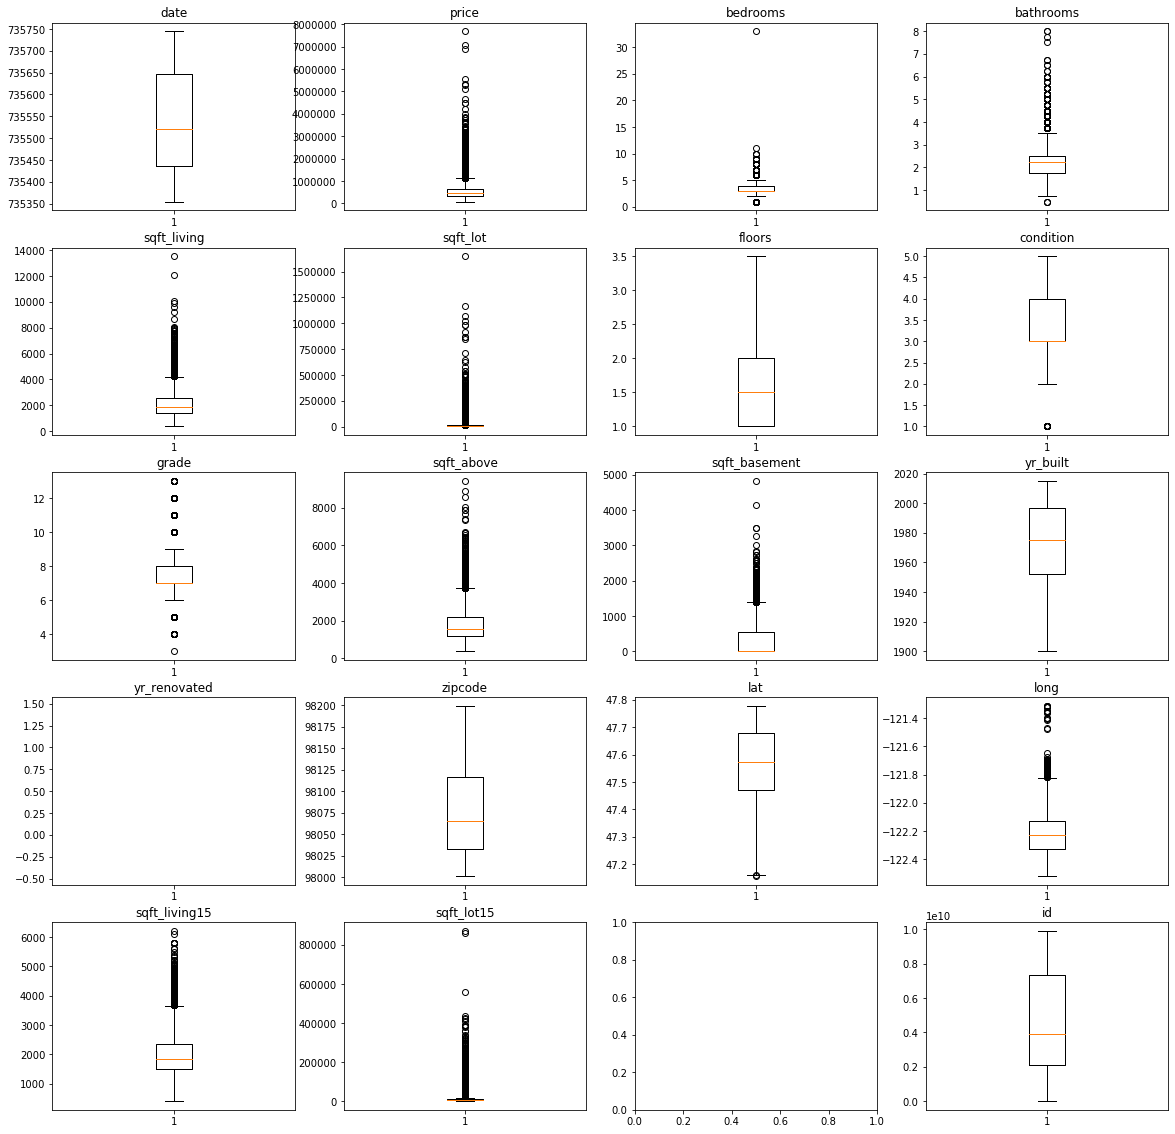

In [16]:
box_list = list(df.columns)
box_list.remove('waterfront')

fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(20,20))
plt.title('Graphs')
for n, column in enumerate(box_list):
    row=(n-1)//4
    col=n%4-1
    ax=axes[row][col]
    x=df[column]
    y=df.price
    ax.boxplot(x=x)
    ax.set_title(box_list[n])
plt.show()   

Box plots show significant outliers in the data possibly due to very large, expensive houses in the dataset.

Investigating independent vs dependent variable relationships via scatterplots

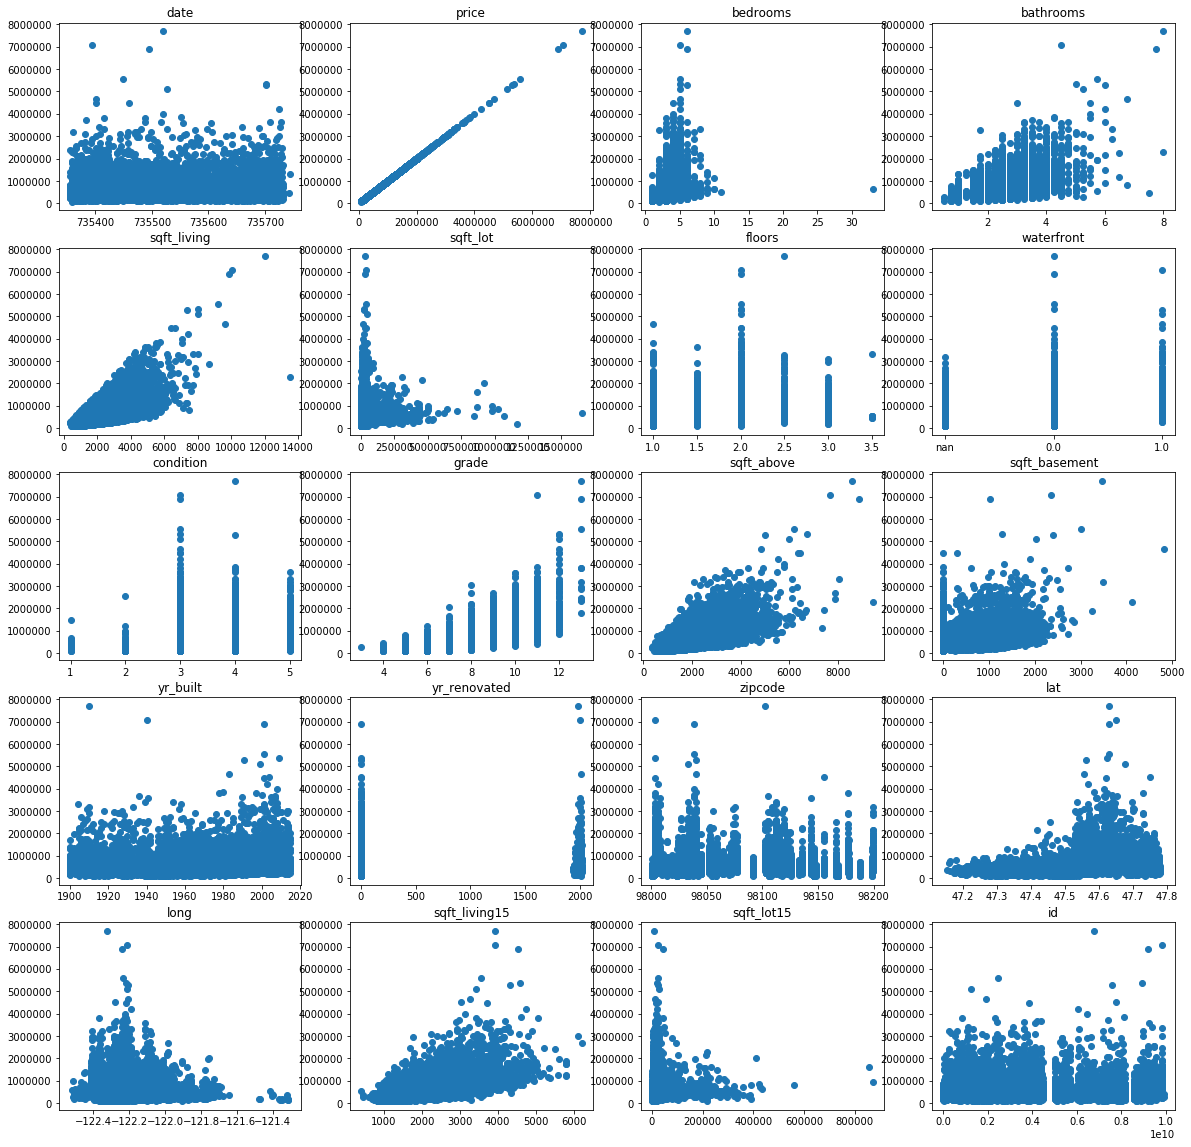

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(20,20))
plt.title('Graphs')
for n, column in enumerate(df.columns):
    row=(n-1)//4
    col=n%4-1
    ax=axes[row][col]
    x=df[column]
    y=df.price
    ax.scatter(x, y)
    ax.set_title(df.columns.values[n])
plt.show()   

Subsetting data for business case - luxury real estate agency looking for the housing attributes that appeal to wealthy people
i.e. What translates to higher listing prices in areas where wealthy people live.
We are luxury real estate company targeting high income buyers. We want to know what features these buyers look for in houses that translate to higher listing prices.

In [18]:
zips = pd.read_csv('data/top_30_zips.csv')
zips

,ZIP,returns,AGI,AGIperReturn
0,98039,1540.0,1808237.0,1174.179870
1,98040,12650.0,4405904.0,348.292806
2,98004,18840.0,6309943.0,334.922665
3,98112,12660.0,4202173.0,331.925197
4,98164,110.0,33940.0,308.545455
5,98134,480.0,121097.0,252.285417
6,98033,19980.0,4917685.0,246.130380
7,98075,10660.0,2564469.0,240.569325
8,98074,12680.0,2992892.0,236.032492
9,98077,6200.0,1416890.0,228.530645


In [19]:
fourteen_zips = list(zips.ZIP[:14])

In [20]:
df["zipcode"].value_counts()

98103    588
98038    574
98115    568
98052    562
98042    542
        ... 
98102    100
98010     98
98024     79
98148     55
98039     49
Name: zipcode, Length: 70, dtype: int64

In [21]:
df_top_zip = df[df["zipcode"].isin(fourteen_zips)]

In [22]:
df_top_zip.shape

(3192, 20)

Checking the distribution of the subset

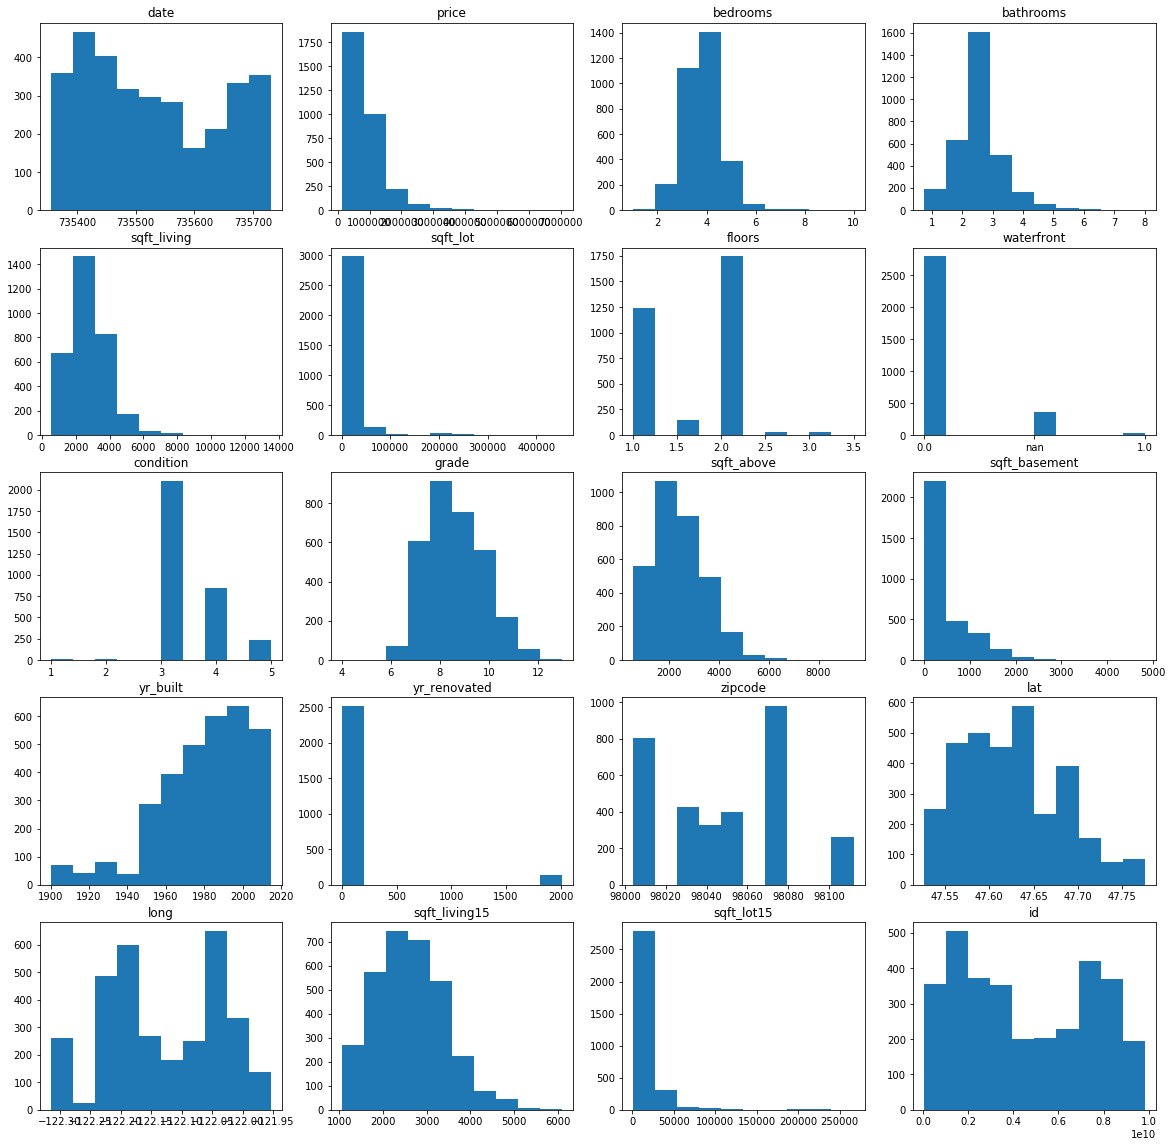

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(20,20))
plt.title('Graphs')
x = df_top_zip.price
for n in range(len(df_top_zip.columns)):
    row=(n-1)//4
    col=n%4-1
    ax=axes[row][col]
    y=df_top_zip.iloc[:,n]
    ax.hist(y)
    ax.set_title(df_top_zip.columns.values[n])
plt.show()   

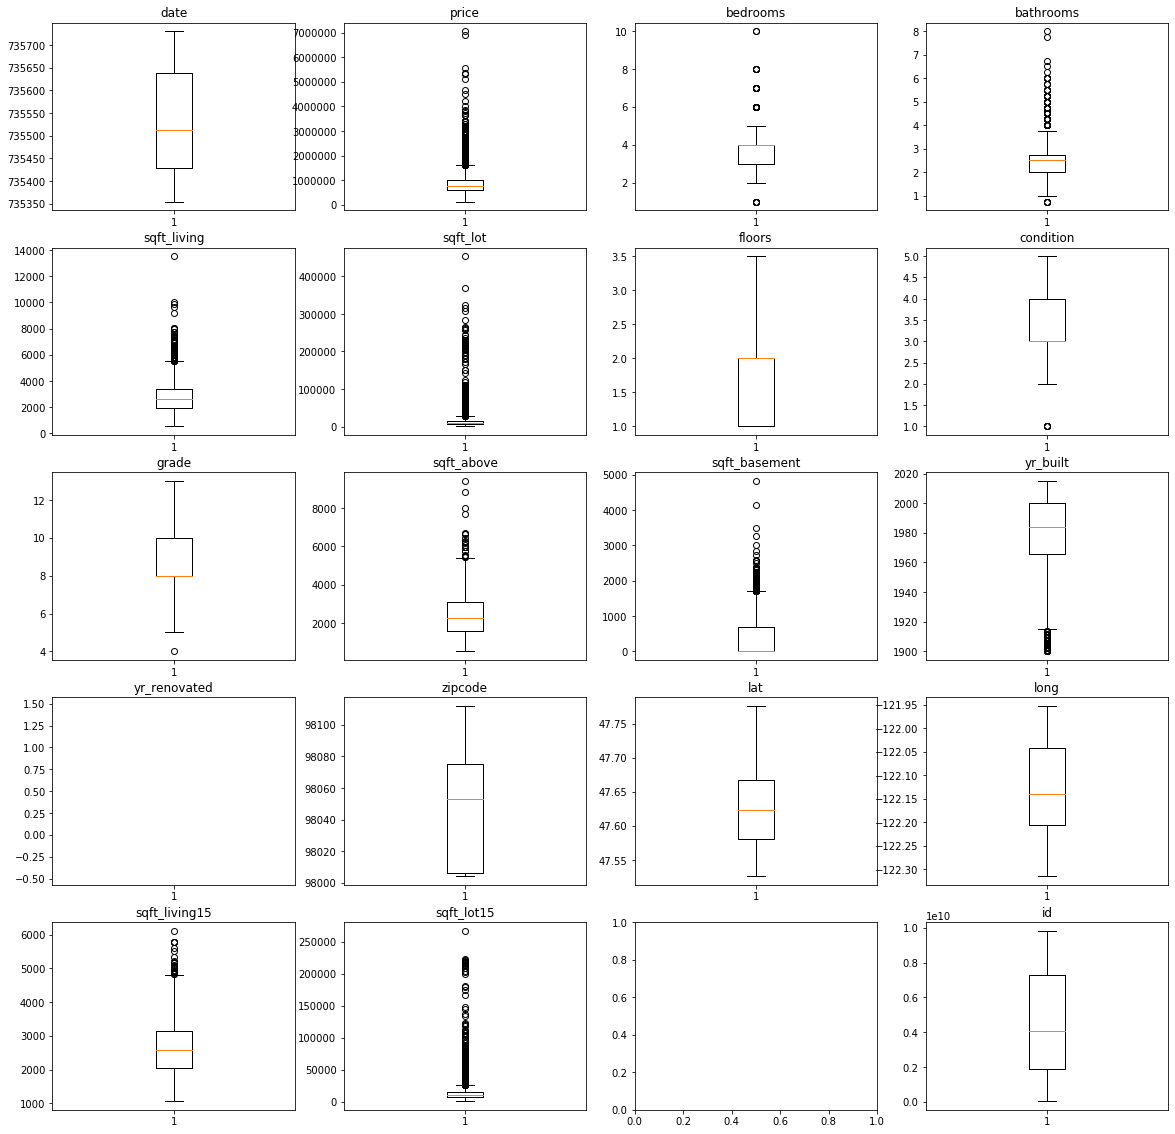

In [24]:
box_list = list(df_top_zip.columns)
box_list.remove('waterfront')

fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(20,20))
plt.title('Graphs')
for n, column in enumerate(box_list):
    row=(n-1)//4
    col=n%4-1
    ax=axes[row][col]
    x=df_top_zip[column]
#     y=df.price
    ax.boxplot(x=x)
    ax.set_title(box_list[n])
plt.show()   

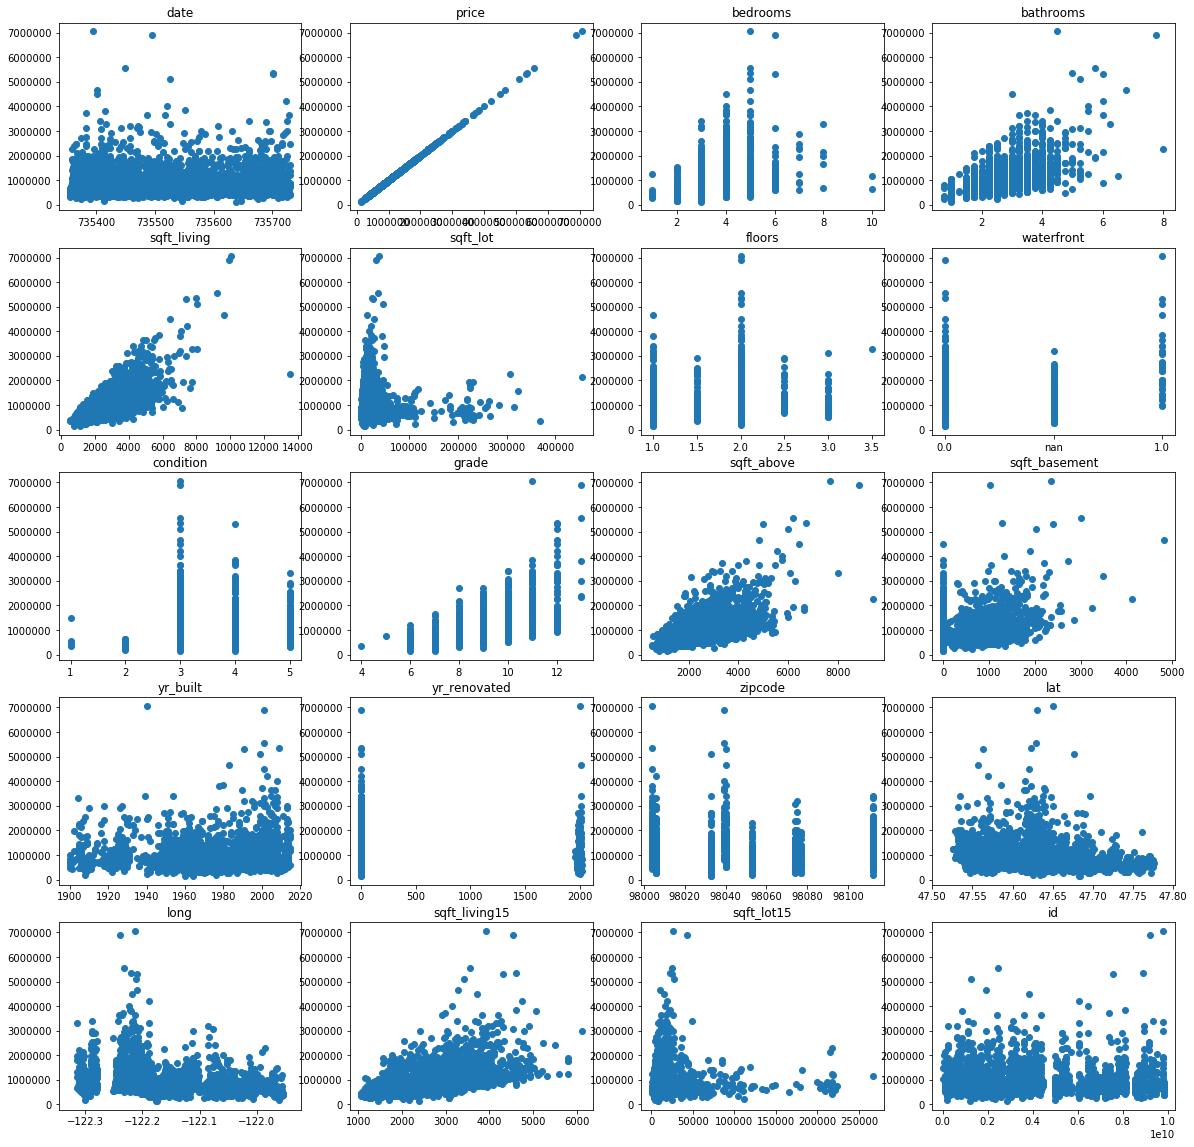

In [25]:
fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(20,20))
plt.title('Graphs')
for n, column in enumerate(df_top_zip.columns):
    row=(n-1)//4
    col=n%4-1
    ax=axes[row][col]
    x=df_top_zip[column]
    y=df_top_zip.price
    ax.scatter(x, y)
    ax.set_title(df_top_zip.columns.values[n])
plt.show()   

Investigating multicollinearity

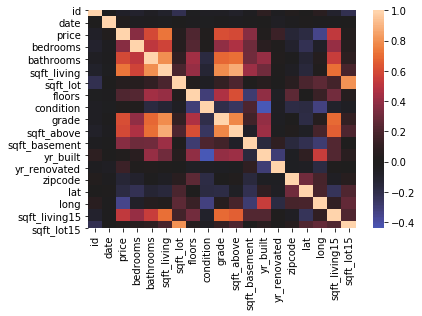

In [33]:
sns.heatmap(df_top_zip.corr(), center=0)

In [34]:
correlation_df = df_top_zip.corr()
correlation_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.004197,-0.072561,-0.097088,-0.048326,-0.087069,-0.212432,-0.030574,-0.053810,-0.048444,-0.083656,-0.022469,0.095123,-0.027294,0.037869,0.007965,0.071681,-0.091226,-0.210786
date,0.004197,1.000000,0.028610,-0.027630,-0.020767,-0.028695,0.005349,-0.021416,-0.031237,-0.013869,-0.026779,-0.008867,-0.000988,-0.045072,-0.020273,0.014711,-0.011753,-0.008908,0.006759
price,-0.072561,0.028610,1.000000,0.370082,0.601021,0.725306,0.047001,0.215821,0.025737,0.615902,0.597040,0.371540,0.023982,0.142075,-0.136483,-0.169639,-0.347710,0.525086,0.038250
bedrooms,-0.097088,-0.027630,0.370082,1.000000,0.520524,0.577827,0.047149,0.235819,0.021688,0.392482,0.471902,0.302899,0.066424,0.018856,-0.094527,-0.222303,-0.075676,0.414127,0.061008
bathrooms,-0.048326,-0.020767,0.601021,0.520524,1.000000,0.803328,0.102307,0.441975,-0.164291,0.685504,0.716726,0.309084,0.406146,0.029782,-0.010975,-0.128821,0.042740,0.549592,0.094366
sqft_living,-0.087069,-0.028695,0.725306,0.577827,0.803328,1.000000,0.198010,0.413557,-0.126011,0.787340,0.871379,0.423196,0.303950,0.016518,-0.049848,-0.155642,0.025892,0.715847,0.190337
sqft_lot,-0.212432,0.005349,0.047001,0.047149,0.102307,0.198010,1.000000,0.034593,-0.046774,0.113314,0.211058,0.012666,0.057087,-0.001842,0.067545,0.198696,0.253471,0.175589,0.805072
floors,-0.030574,-0.021416,0.215821,0.235819,0.441975,0.413557,0.034593,1.000000,-0.304394,0.476624,0.611760,-0.289251,0.396076,-0.059928,0.253490,0.002162,0.134946,0.317765,0.045789
condition,-0.053810,-0.031237,0.025737,0.021688,-0.164291,-0.126011,-0.046774,-0.304394,1.000000,-0.201122,-0.251023,0.207472,-0.438029,-0.050418,-0.180276,-0.172372,-0.320243,-0.089197,-0.051811
grade,-0.048444,-0.013869,0.615902,0.392482,0.685504,0.787340,0.113314,0.476624,-0.201122,1.000000,0.777299,0.164724,0.399951,-0.040987,0.001298,-0.181413,0.052870,0.695382,0.117474


In [35]:
correlation_df.applymap(lambda val: abs(val) >= 0.75)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
date,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
floors,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False


In [36]:
corr_data = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_data[corr_data[0] < 1][:20]

,level_0,level_1,0
195,sqft_above,sqft_living,0.876678
105,sqft_living,sqft_above,0.876678
104,sqft_living,grade,0.763101
176,grade,sqft_living,0.763101
328,sqft_living15,sqft_living,0.756389
112,sqft_living,sqft_living15,0.756389
181,grade,sqft_above,0.756382
199,sqft_above,grade,0.756382
99,sqft_living,bathrooms,0.755278
81,bathrooms,sqft_living,0.755278


It appears that there is strong correlation between:
 - sqft living/sqft above
 - sqft living/grade
 - sqft living 15/sqft living
 - grade/sqft above
 - bathrooms/sqft living

Further investigating multicollinearity of subset of independent variables

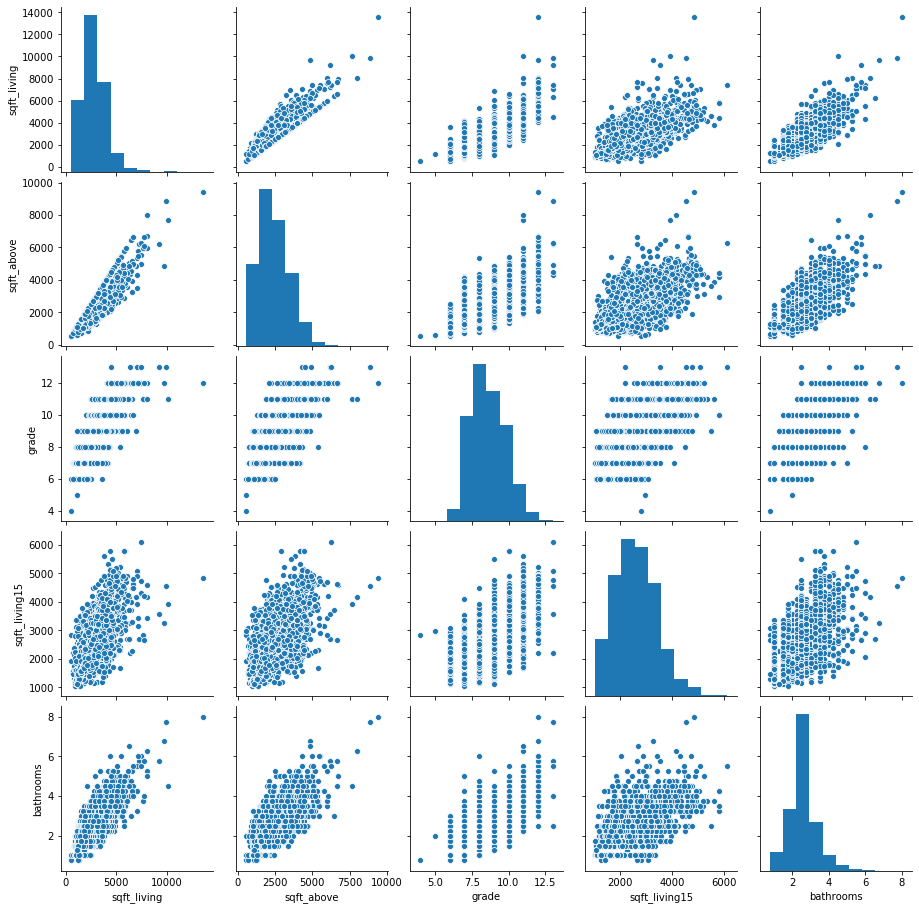

In [37]:
sns.pairplot(df_top_zip[["sqft_living", "sqft_above", "grade", "sqft_living15", "bathrooms"]])

Creating dummy variables for categorical data so they can be read into model

In [38]:
categorical = ["waterfront", "condition", "grade", "floors", "bedrooms", "zipcode"]
continuous = ["id", "date", "price", "bathrooms", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "yr_built", "lat", "long", "sqft_living15", "sqft_lot15"]

** year renovated was not included in categorical list, as it was added manually as a dummy variable

Creating dummy variables for year renovated

In [39]:
df_top_zip["reno_2000_over"] = df_top_zip["yr_renovated"].map(lambda year: 1 if year >= 2000 else 0)

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
df_top_zip["reno_1980_2000"] = df_top_zip["yr_renovated"].map(lambda year: 1 if (year >= 1980 and year < 2000) else 0)

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
df_top_zip["reno_1960_1980"] = df_top_zip["yr_renovated"].map(lambda year: 1 if (year >= 1960 and year < 1980) else 0)

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
df_top_zip["reno_1940_1960"] = df_top_zip["yr_renovated"].map(lambda year: 1 if (year >= 1940 and year < 1960) else 0)

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
df_top_zip["reno_1920_1940"] = df_top_zip["yr_renovated"].map(lambda year: 1 if (year >= 1920 and year < 1940) else 0)

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
df_top_zip["reno_never"] = df_top_zip["yr_renovated"].map(lambda year: 1 if year == 0 else 0)

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
df_top_zip["yr_renovated"].fillna("nan")

4          0
5          0
13         0
21         0
27         0
        ... 
21536      0
21552      0
21574      0
21583    nan
21584      0
Name: yr_renovated, Length: 3192, dtype: object

In [46]:
df_top_zip["reno_nan"] = df_top_zip["yr_renovated"].map(lambda year:  1 if np.isnan(year) else 0)

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
df_nona = df_top_zip.drop(columns = ["yr_renovated", "reno_nan"])

In [48]:
df_cat = pd.DataFrame([])

for col in categorical:
    df_cat = pd.concat([df_cat, pd.get_dummies(df_nona[col], prefix= col[:3], drop_first=True)], axis=1)

In [49]:
df_cat

,wat_1.0,wat_nan,con_2,con_3,con_4,con_5,gra_5,gra_6,gra_7,gra_8,...,bed_10,zip_98006,zip_98033,zip_98039,zip_98040,zip_98053,zip_98074,zip_98075,zip_98077,zip_98112
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
13,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
21,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
27,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21552,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21574,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21583,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [50]:
df_joined = pd.concat([df_nona, df_cat], axis=1)

In [51]:
df_joined.drop(columns = categorical, axis=1, inplace = True)

Exporting data to csv

In [52]:
df_joined.to_csv("data/df_joined.csv", index=False)

We will now remove price outliers from the dataset before our train test split, and check the new distribution

In [53]:
def remove_outliers(df, column_name):
    q1 = df[column_name].describe()['25%']
    q3 = df[column_name].describe()['75%']
    iqr = q3 - q1
    return df.loc[(df[column_name]>=(q1-(1.5*iqr))) & (df[column_name]<=(q3+(1.5*iqr)))]

(array([1861., 1004.,  221.,   68.,   22.,    8.,    2.,    4.,    0.,
           2.]),
 array([ 130000.,  823000., 1516000., 2209000., 2902000., 3595000.,
        4288000., 4981000., 5674000., 6367000., 7060000.]),
 <a list of 10 Patch objects>)

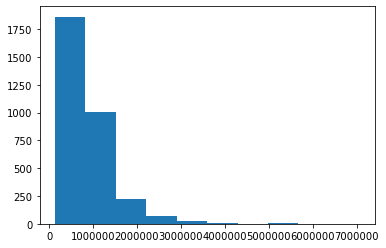

In [54]:
plt.hist(x=df_joined["price"])

(array([ 12., 192., 531., 674., 625., 383., 168., 144., 104.,  85.]),
 array([ 130000.,  278000.,  426000.,  574000.,  722000.,  870000.,
        1018000., 1166000., 1314000., 1462000., 1610000.]),
 <a list of 10 Patch objects>)

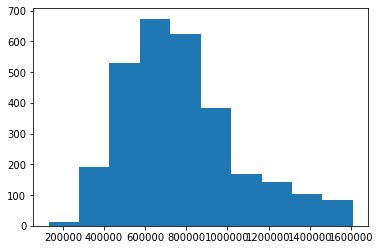

In [55]:
plt.hist(x = remove_outliers(df_joined, "price")["price"])

In [56]:
y = remove_outliers(df_joined, "price")["price"]
X = remove_outliers(df_joined, "price").drop(columns = "price", axis=1)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [58]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train ,X_int).fit()
summary = model.summary()
summary

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     160.6
Date:                Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:56:55   Log-Likelihood:                -30867.
No. Observations:                2334   AIC:                         6.184e+04
Df Residuals:                    2283   BIC:                         6.213e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.502e+08   2.53e+07     -9.879      0.000      -3e+08      -2e+08
id             -8.114e-07   1.04e-06     -0.778      0.436   -2.86e-06    1.23e-06
date             105.5687     25.081      4.209      0.000      56.385     154.753
bathrooms       3.672e+04   6882.165      5.335      0.000    2.32e+04    5.02e+04
sqft_living       76.4520      4.562     16.759      0.000      67.506      85.398
sqft_lot           0.2518      0.163      1.540      0.124      -0.069       0.572
sqft_above        60.7503      4.521     13.436      0.000      51.884      69.617
sqft_basement     15.0964      4.986      3.028      0.002       5.318      24.875
yr_built         446.6796    226.002      1.976      0.048       3.489     889.870
lat             5.342e+05   1.89e+05      2.824      0.005    1.63e+05    9.05e+05
long           -1.199e+06   1.41e+05     -8.488      0.000   -1.48e+06   -9.22e+05
sqft_living15     54.2103      6.360      8.523      0.000      41.738      66.683
sqft_lot15         0.0383      0.217      0.177      0.860      -0.386       0.463
reno_2000_over  5.832e+04   2.41e+04      2.417      0.016     1.1e+04    1.06e+05
reno_1980_2000   3.74e+04   2.71e+04      1.382      0.167   -1.57e+04    9.05e+04
reno_1960_1980 -9.071e+04   5.49e+04     -1.652      0.099   -1.98e+05     1.7e+04
reno_1940_1960  1.689e+05   9.95e+04      1.697      0.090   -2.63e+04    3.64e+05
reno_1920_1940   5.14e-07    2.9e-07      1.773      0.076   -5.46e-08    1.08e-06
reno_never      -1.76e+04   7590.431     -2.318      0.021   -3.25e+04   -2712.339
wat_1.0         5.291e+05   6.05e+04      8.752      0.000    4.11e+05    6.48e+05
wat_nan        -7507.3223   8958.592     -0.838      0.402   -2.51e+04    1.01e+04
con_2           4.672e+04    8.2e+04      0.570      0.569   -1.14e+05    2.08e+05
con_3           9.929e+04   6.87e+04      1.446      0.148   -3.54e+04    2.34e+05
con_4           1.311e+05   6.85e+04      1.913      0.056   -3285.742    2.65e+05
con_5            1.89e+05   6.92e+04      2.732      0.006    5.34e+04    3.25e+05
gra_5           3.921e+05   2.19e+05      1.793      0.073   -3.68e+04    8.21e+05
gra_6           7.985e+04   1.72e+05      0.463      0.643   -2.58e+05    4.18e+05
gra_7           9.158e+04   1.71e+05      0.535      0.593   -2.44e+05    4.28e+05
gra_8           1.431e+05   1.71e+05      0.836      0.403   -1.92e+05    4.79e+05
gra_9           2.345e+05   1.71e+05      1.368      0.172   -1.02e+05    5.71e+05
gra_10          2.763e+05   1.72e+05      1.609      0.108   -6.04e+04    6.13e+05
gra_11          3.711e+05   1.72e+05      2.155      0.031    3.34e+04    7.09e+05
gra_12          4.611e+05   1.75e+05      2.630      0.009    1.17e+05    8.05e+05
gra_13         -9.293e-11   8.63e-11     -1.076      0.282   -2.62e-10    7.64e-11
flo_1.5     

In [59]:
y_hat = model.predict()
train_rmse = mean_squared_error(y_train,y_hat)**.5
train_rmse

134041.96298701665

In [60]:
p_table = summary.tables[1]
p_table

,coef,std err,t,P>|t|,[0.025,0.975]
const,-2.502e+08,2.53e+07,-9.879,0.000,-3e+08,-2e+08
id,-8.114e-07,1.04e-06,-0.778,0.436,-2.86e-06,1.23e-06
date,105.5687,25.081,4.209,0.000,56.385,154.753
bathrooms,3.672e+04,6882.165,5.335,0.000,2.32e+04,5.02e+04
sqft_living,76.4520,4.562,16.759,0.000,67.506,85.398
sqft_lot,0.2518,0.163,1.540,0.124,-0.069,0.572
sqft_above,60.7503,4.521,13.436,0.000,51.884,69.617
sqft_basement,15.0964,4.986,3.028,0.002,5.318,24.875
yr_built,446.6796,226.002,1.976,0.048,3.489,889.870
lat,5.342e+05,1.89e+05,2.824,0.005,1.63e+05,9.05e+05


Check normality assumption with QQ plot

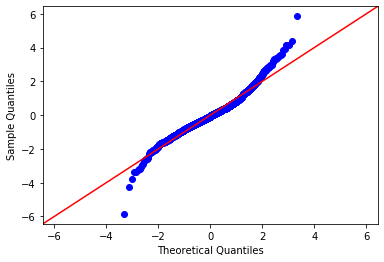

In [61]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

This QQ plot indicates that our data has very heavy tails compared to a normal distribution of residuals.

In [62]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 666.7129357958048),
 ('Prob', 1.6792891623624488e-145),
 ('Skew', 0.46845304021746154),
 ('Kurtosis', 5.444967689894317)]

The Jarque-Bera result is very high indicating that our results are not normally distributed.

Next we will check for homoscedasticity.

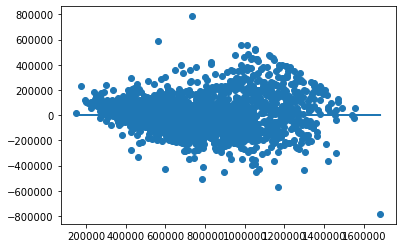

In [63]:
plt.scatter(model.predict(X_int), model.resid)
plt.plot(model.predict(X_int), [0 for i in range(len(X_int))]);

This displays a slight 'funnel' shape: errors appear to increase as the list_price reaches 1 million, then decrease. This indicates slight heteroscadasticity

In [64]:
p_table_df = pd.DataFrame(p_table.data)
p_table_df.columns=['column','coef','std err','t','P>|t|','0.025','0.975']
p_table_df.drop(labels=0,axis=0,inplace=True)
p_table_df.set_index('column',inplace=True)
p_table_df['P>|t|'] = p_table_df['P>|t|'].astype(float)
p_table_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, const to zip_98112
Data columns (total 6 columns):
coef       56 non-null object
std err    56 non-null object
t          56 non-null object
P>|t|      56 non-null float64
0.025      56 non-null object
0.975      56 non-null object
dtypes: float64(1), object(5)
memory usage: 3.1+ KB


In [65]:
p_table_df['pass']=p_table_df['P>|t|'].map(lambda x: x<=.05)
pass_list=list(p_table_df[p_table_df['pass']==True].index)
pass_list

['const',
 'date',
 'bathrooms',
 'sqft_living',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'sqft_living15',
 'reno_2000_over',
 'reno_never',
 'wat_1.0',
 'con_5',
 'gra_11',
 'gra_12',
 'flo_2.0',
 'flo_3.0',
 'bed_7',
 'zip_98006',
 'zip_98033',
 'zip_98039',
 'zip_98040',
 'zip_98053',
 'zip_98074',
 'zip_98075',
 'zip_98077',
 'zip_98112']

In [66]:
len(pass_list)

28

Of our 55 number of independent variables, 27 have significantly low p-values so we can reject the null hypothesis that there is no relationship between these variables and the dependent variable.

In [67]:
pass_list.remove('const')
trained2 = X_train[pass_list]

In [68]:
trained2.corr().applymap(lambda val: abs(val) >= 0.75)

,date,bathrooms,sqft_living,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,reno_2000_over,...,bed_7,zip_98006,zip_98033,zip_98039,zip_98040,zip_98053,zip_98074,zip_98075,zip_98077,zip_98112
date,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_basement,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yr_built,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
lat,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
long,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living15,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
reno_2000_over,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [69]:
corr_data = trained2.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_data[corr_data[0] < 1][:20]

,level_0,level_1,0
83,sqft_above,sqft_living,0.856139
57,sqft_living,sqft_above,0.856139
29,bathrooms,sqft_living,0.757508
55,sqft_living,bathrooms,0.757508
218,sqft_living15,sqft_living,0.749152
62,sqft_living,sqft_living15,0.749152
89,sqft_above,sqft_living15,0.693520
219,sqft_living15,sqft_above,0.693520
30,bathrooms,sqft_above,0.658669
82,sqft_above,bathrooms,0.658669


There seems to be significant multicollinearity between certain independent variables. To reduce this, we will remove sqft living which seems to be highly correlated with many variables.

In [70]:
trained2.drop(columns = "sqft_living", inplace = True)

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Feature engineering the test data in the same way as the trained data

In [71]:
test2 = X_test[pass_list]
test2.drop(columns = "sqft_living", inplace = True)

In [72]:
X_int_2 = sm.add_constant(trained2)
model2 = sm.OLS(y_train, X_int_2).fit()
summary2 = model2.summary()
summary2

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     270.6
Date:                Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:03:33   Log-Likelihood:                -30994.
No. Observations:                2334   AIC:                         6.204e+04
Df Residuals:                    2307   BIC:                         6.220e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.596e+08   2.62e+07     -9.925      0.000   -3.11e+08   -2.08e+08
date             116.7319     26.222      4.452      0.000      65.311     168.153
bathrooms       3.411e+04   6959.709      4.901      0.000    2.05e+04    4.78e+04
sqft_above       170.1643      6.752     25.201      0.000     156.923     183.406
sqft_basement    103.1606      8.299     12.431      0.000      86.887     119.434
yr_built         988.7289    204.387      4.838      0.000     587.928    1389.530
lat             4.469e+05   1.91e+05      2.339      0.019    7.22e+04    8.22e+05
long           -1.235e+06   1.45e+05     -8.502      0.000   -1.52e+06    -9.5e+05
sqft_living15     80.2275      6.338     12.659      0.000      67.799      92.656
reno_2000_over  4.782e+04   2.47e+04      1.936      0.053    -617.297    9.63e+04
reno_never         -2e+04   7679.630     -2.605      0.009   -3.51e+04   -4944.899
wat_1.0         5.407e+05   6.01e+04      8.993      0.000    4.23e+05    6.59e+05
con_5           6.707e+04   1.25e+04      5.354      0.000    4.25e+04    9.16e+04
gra_11           9.28e+04    1.5e+04      6.178      0.000    6.33e+04    1.22e+05
gra_12          1.449e+05   3.63e+04      3.994      0.000    7.37e+04    2.16e+05
flo_2.0        -4.156e+04   8884.142     -4.678      0.000    -5.9e+04   -2.41e+04
flo_3.0        -8.894e+04    3.5e+04     -2.539      0.011   -1.58e+05   -2.03e+04
bed_7          -6.167e+05   1.45e+05     -4.259      0.000   -9.01e+05   -3.33e+05
zip_98006      -2.493e+05   1.81e+04    -13.777      0.000   -2.85e+05   -2.14e+05
zip_98033      -2.769e+05   1.86e+04    -14.906      0.000   -3.13e+05    -2.4e+05
zip_98039       1.194e+05   4.46e+04      2.679      0.007     3.2e+04    2.07e+05
zip_98040       -1.33e+05   1.85e+04     -7.202      0.000   -1.69e+05   -9.68e+04
zip_98053      -2.454e+05   3.26e+04     -7.526      0.000   -3.09e+05   -1.81e+05
zip_98074      -2.464e+05   2.63e+04     -9.350      0.000   -2.98e+05   -1.95e+05
zip_98075      -2.071e+05   2.93e+04     -7.066      0.000   -2.65e+05    -1.5e+05
zip_98077      -3.673e+05   3.78e+04     -9.719      0.000   -4.41e+05   -2.93e+05
zip_98112      -1.562e+05   2.09e+04     -7.459      0.000   -1.97e+05   -1.15e+05
==============================================================================
Omnibus:                      224.323   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.527
Skew:                           0.484   Prob(JB):                    7.63e-153
Kurtosis:                       5.503   Cond. No.                     6.53e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The conditio

In [73]:
y_hat2 = model2.predict()
train_rmse2 = mean_squared_error(y_train ,y_hat2)**.5
train_rmse2

141559.428288108

Our r squared value decreased signifying that less variance in the data is explained by the model, the root mean square error increased, signifying slightly more average error when predicting. However, the p-values in the model are now mostly significant in terms of their relationship with the dependent variable.

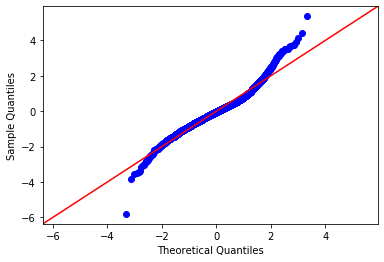

In [75]:
fig = sm.graphics.qqplot(model2.resid, dist=stats.norm, line='45', fit=True)

The residuals appear to be similarly distributed in this second iteration of the model as in the first.

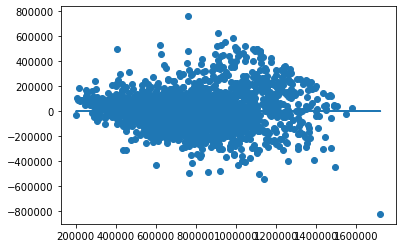

In [77]:
plt.scatter(model2.predict(X_int_2), model2.resid)
plt.plot(model2.predict(X_int_2), [0 for i in range(len(X_int_2))]);

The heteroscedasticity of the data appears to be largely unchanged. 

We will now feature engineer for the third iteration of the model by removing other independent variables that are not significant based on their p_values and multicollinearity

In [80]:
trained3 = trained2.drop(columns = ["reno_2000_over"])

In [81]:
trained3.corr().applymap(lambda val: abs(val) >= 0.75)

,date,bathrooms,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,reno_never,wat_1.0,...,bed_7,zip_98006,zip_98033,zip_98039,zip_98040,zip_98053,zip_98074,zip_98075,zip_98077,zip_98112
date,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_basement,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yr_built,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
lat,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
long,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living15,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
reno_never,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
wat_1.0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [82]:
corr_data = trained3.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_data[corr_data[0] < 1][:20]

,level_0,level_1,0
177,sqft_living15,sqft_above,0.693520
57,sqft_above,sqft_living15,0.693520
51,sqft_above,bathrooms,0.658669
27,bathrooms,sqft_above,0.658669
327,flo_2.0,sqft_above,0.630580
63,sqft_above,flo_2.0,0.630580
154,long,yr_built,0.589931
106,yr_built,long,0.589931
580,zip_98077,lat,0.557837
148,lat,zip_98077,0.557837


While there are no extremely correlated features (above 0.75) there still seems to be potential mulitcollinearity between sqft_above and other features. We will remove sqft_above to see if it improves the model.

In [83]:
trained3.drop(columns = "sqft_above", inplace = True)

dropping features from test data that are not included in model

In [84]:
test3 = test2.drop(columns = ["sqft_above"])

In [85]:
len(trained3), len(y_train)

(2334, 2334)

In [86]:
X_int_3 = sm.add_constant(trained3)
model3 = sm.OLS(y_train, X_int_3).fit()
summary3 = model3.summary()
summary3

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     209.1
Date:                Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:11:52   Log-Likelihood:                -31279.
No. Observations:                2334   AIC:                         6.261e+04
Df Residuals:                    2309   BIC:                         6.275e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.286e+08   2.95e+07     -7.751      0.000   -2.86e+08   -1.71e+08
date            100.3252     29.596      3.390      0.001      42.289     158.362
bathrooms      1.165e+05   6909.634     16.859      0.000    1.03e+05     1.3e+05
sqft_basement    15.3388      8.495      1.806      0.071      -1.319      31.997
yr_built        890.2440    228.998      3.888      0.000     441.181    1339.307
lat            4.949e+05   2.16e+05      2.295      0.022     7.2e+04    9.18e+05
long          -1.063e+06   1.64e+05     -6.493      0.000   -1.38e+06   -7.42e+05
sqft_living15   165.0831      6.023     27.409      0.000     153.272     176.894
reno_never    -2.272e+04   8409.733     -2.701      0.007   -3.92e+04   -6227.440
wat_1.0         4.24e+05   6.77e+04      6.265      0.000    2.91e+05    5.57e+05
con_5          5.333e+04   1.41e+04      3.784      0.000    2.57e+04     8.1e+04
gra_11         1.533e+05   1.67e+04      9.161      0.000    1.21e+05    1.86e+05
gra_12         2.115e+05   4.08e+04      5.178      0.000    1.31e+05    2.92e+05
flo_2.0        2.024e+04   9643.525      2.099      0.036    1330.728    3.92e+04
flo_3.0       -4.439e+04   3.95e+04     -1.124      0.261   -1.22e+05    3.31e+04
bed_7         -2.533e+05   1.63e+05     -1.557      0.120   -5.72e+05    6.57e+04
zip_98006     -2.552e+05   2.04e+04    -12.493      0.000   -2.95e+05   -2.15e+05
zip_98033     -2.778e+05    2.1e+04    -13.255      0.000   -3.19e+05   -2.37e+05
zip_98039      1.049e+05   5.03e+04      2.084      0.037    6202.992    2.04e+05
zip_98040     -1.214e+05   2.08e+04     -5.822      0.000   -1.62e+05   -8.05e+04
zip_98053     -2.558e+05   3.68e+04     -6.949      0.000   -3.28e+05   -1.84e+05
zip_98074     -2.712e+05   2.97e+04     -9.123      0.000    -3.3e+05   -2.13e+05
zip_98075     -2.241e+05   3.31e+04     -6.778      0.000   -2.89e+05   -1.59e+05
zip_98077     -3.706e+05   4.27e+04     -8.684      0.000   -4.54e+05   -2.87e+05
zip_98112     -1.531e+05   2.36e+04     -6.498      0.000   -1.99e+05   -1.07e+05
==============================================================================
Omnibus:                      223.896   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.445
Skew:                           0.577   Prob(JB):                    1.18e-112
Kurtosis:                       4.993   Cond. No.                     6.52e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.52e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
y_hat3 = model3.predict()
train_rmse3 = mean_squared_error(y_train ,y_hat3)**.5
train_rmse3

159918.8341062173

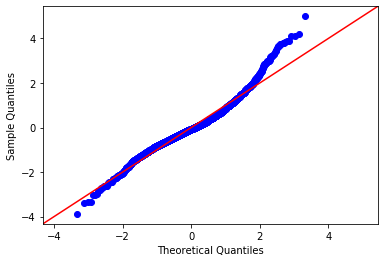

In [88]:
fig = sm.graphics.qqplot(model3.resid, dist=stats.norm, line='45', fit=True)

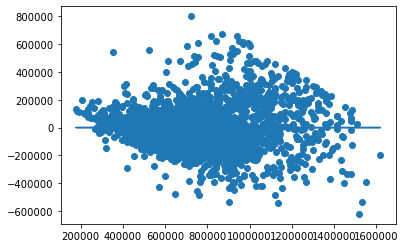

In [89]:
plt.scatter(model3.predict(X_int_3), model3.resid)
plt.plot(model3.predict(X_int_3), [0 for i in range(len(X_int_3))]);

In this third iteration of the model, the r squared has decreased and our mean square error increases. The model displays slightly more normally distributed residuals, but still some heteroscedasticity. It appears that the previous changes did not improve the model significantly. 

We will try adding back in sqft_above to the model for the fourth iteration.

In [90]:
trained4 = trained2.drop(columns = ["reno_2000_over"])

In [91]:
test4 = test2.drop(columns = ["reno_2000_over"])

In [92]:
X_int_4 = sm.add_constant(trained4)
model4 = sm.OLS(y_train, X_int_4).fit()
summary4 = model4.summary()
summary4

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     280.9
Date:                Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:14:54   Log-Likelihood:                -30996.
No. Observations:                2334   AIC:                         6.204e+04
Df Residuals:                    2308   BIC:                         6.219e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.608e+08   2.62e+07     -9.967      0.000   -3.12e+08   -2.09e+08
date            115.6944     26.232      4.410      0.000      64.254     167.135
bathrooms      3.573e+04   6913.464      5.168      0.000    2.22e+04    4.93e+04
sqft_above      169.9176      6.755     25.154      0.000     156.671     183.164
sqft_basement   103.4460      8.302     12.460      0.000      87.166     119.726
yr_built        939.5982    202.926      4.630      0.000     541.662    1337.534
lat            4.593e+05   1.91e+05      2.404      0.016    8.46e+04    8.34e+05
long          -1.247e+06   1.45e+05     -8.587      0.000   -1.53e+06   -9.62e+05
sqft_living15    79.4780      6.330     12.556      0.000      67.065      91.891
reno_never    -2.363e+04   7452.005     -3.171      0.002   -3.82e+04   -9018.580
wat_1.0        5.378e+05   6.01e+04      8.942      0.000     4.2e+05    6.56e+05
con_5          6.518e+04   1.25e+04      5.216      0.000    4.07e+04    8.97e+04
gra_11         9.245e+04    1.5e+04      6.152      0.000     6.3e+04    1.22e+05
gra_12         1.446e+05   3.63e+04      3.985      0.000    7.34e+04    2.16e+05
flo_2.0       -4.115e+04   8886.891     -4.630      0.000   -5.86e+04   -2.37e+04
flo_3.0       -8.825e+04    3.5e+04     -2.518      0.012   -1.57e+05   -1.95e+04
bed_7         -6.203e+05   1.45e+05     -4.282      0.000   -9.04e+05   -3.36e+05
zip_98006     -2.487e+05   1.81e+04    -13.737      0.000   -2.84e+05   -2.13e+05
zip_98033     -2.783e+05   1.86e+04    -14.989      0.000   -3.15e+05   -2.42e+05
zip_98039        1.2e+05   4.46e+04      2.692      0.007    3.26e+04    2.08e+05
zip_98040     -1.331e+05   1.85e+04     -7.204      0.000   -1.69e+05   -9.69e+04
zip_98053     -2.449e+05   3.26e+04     -7.507      0.000   -3.09e+05   -1.81e+05
zip_98074     -2.454e+05   2.64e+04     -9.311      0.000   -2.97e+05   -1.94e+05
zip_98075     -2.052e+05   2.93e+04     -7.002      0.000   -2.63e+05   -1.48e+05
zip_98077     -3.679e+05   3.78e+04     -9.730      0.000   -4.42e+05   -2.94e+05
zip_98112     -1.594e+05   2.09e+04     -7.636      0.000      -2e+05   -1.18e+05
==============================================================================
Omnibus:                      224.306   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              708.080
Skew:                           0.481   Prob(JB):                    1.75e-154
Kurtosis:                       5.521   Cond. No.                     6.53e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.53e+09. This might indicate that there are
strong multicollinearity or other numerical prob

In [93]:
y_hat4 = model4.predict()
train_rmse4 = mean_squared_error(y_train ,y_hat4)**.5
train_rmse4

141674.3751881596

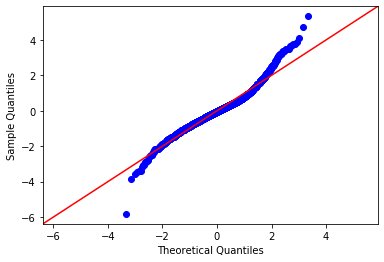

In [94]:
fig = sm.graphics.qqplot(model4.resid, dist=stats.norm, line='45', fit=True)

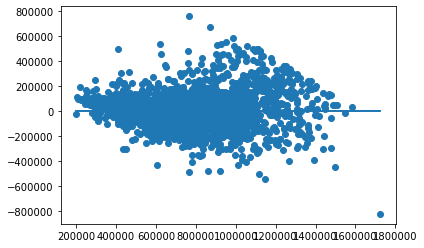

In [95]:
plt.scatter(model4.predict(X_int_4), model4.resid)
plt.plot(model4.predict(X_int_4), [0 for i in range(len(X_int_4))]);

While the model improved from adding sqft_above back in as an independent variable, it shows similar accuracy average error as model 2, therefore implying that removing renovations from year 2000 and on had little effect.

Before continuing the iterations, we will run our model on our test set to see if the difference in RSME indicates overfitting

In [97]:
yhat_test = model4.predict(sm.add_constant(test4))

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [98]:
yhat_test

3211     6.225366e+05
15378    4.891039e+05
12183    6.876565e+05
2042     1.104787e+06
4710     7.285789e+05
             ...     
5048     5.639126e+05
11053    7.298729e+05
11754    4.742048e+05
16615    6.721425e+05
6349     1.182858e+06
Length: 584, dtype: float64

In [99]:
test_rmse = mean_squared_error(y_test, yhat_test)**.5
test_rmse

148412.71004992892

Our training RSME was 141674 versus our testing RSME which was 148412. This indicates that our model has slightly less error in the training data, but still performs fairly well on new data. Therefore, the model doesnt seem to be overfitted.

### Transforming, scaling and other model improvements ###

Rexamining the relationships between independent and dependent variables, as well as variable distributions

In [101]:
train4_df = pd.concat([trained4, y_train], axis=1)

In [109]:
train4_df.columns

Index(['date', 'bathrooms', 'sqft_above', 'sqft_basement', 'yr_built', 'lat',
       'long', 'sqft_living15', 'reno_never', 'wat_1.0', 'con_5', 'gra_11',
       'gra_12', 'flo_2.0', 'flo_3.0', 'bed_7', 'zip_98006', 'zip_98033',
       'zip_98039', 'zip_98040', 'zip_98053', 'zip_98074', 'zip_98075',
       'zip_98077', 'zip_98112', 'price'],
      dtype='object')

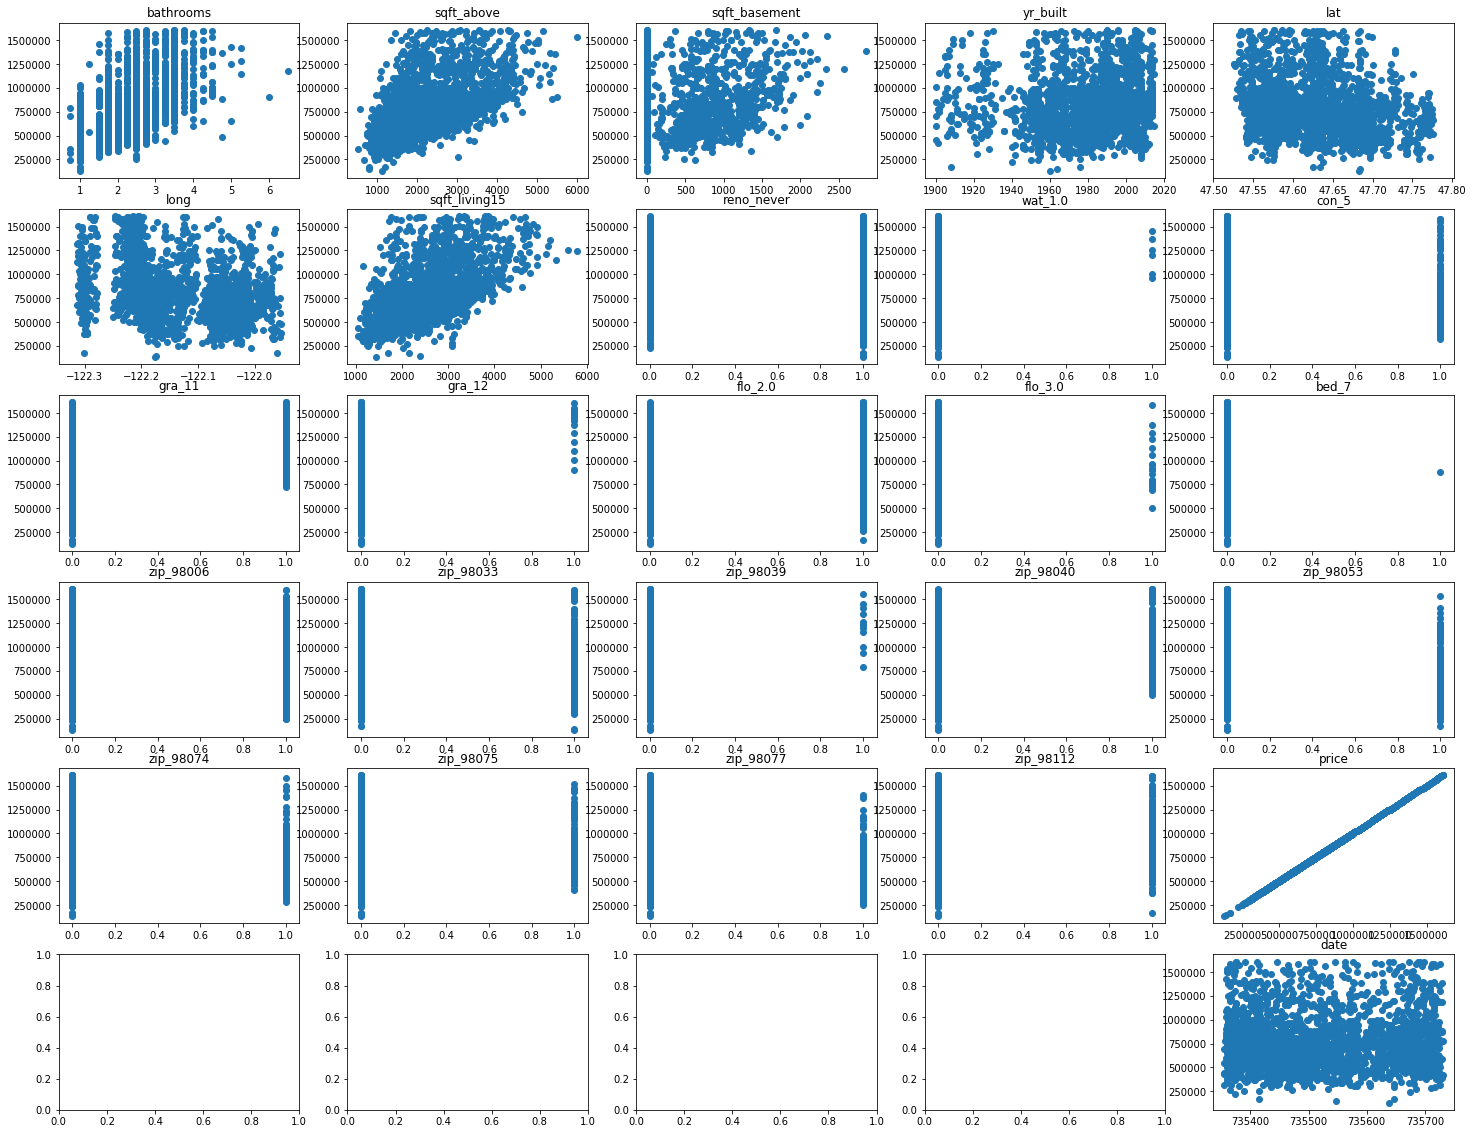

In [112]:
fig, axes = plt.subplots(nrows=6, ncols=5,figsize=(25,20))
plt.title('Graphs')
for n, column in enumerate(train4_df.columns):
    row=(n-1)//5
    col=n%5 -1
    ax=axes[row][col]
    x=train4_df[column]
    y=train4_df.price
    ax.scatter(x, y)
    ax.set_title(train4_df.columns.values[n])
plt.show()

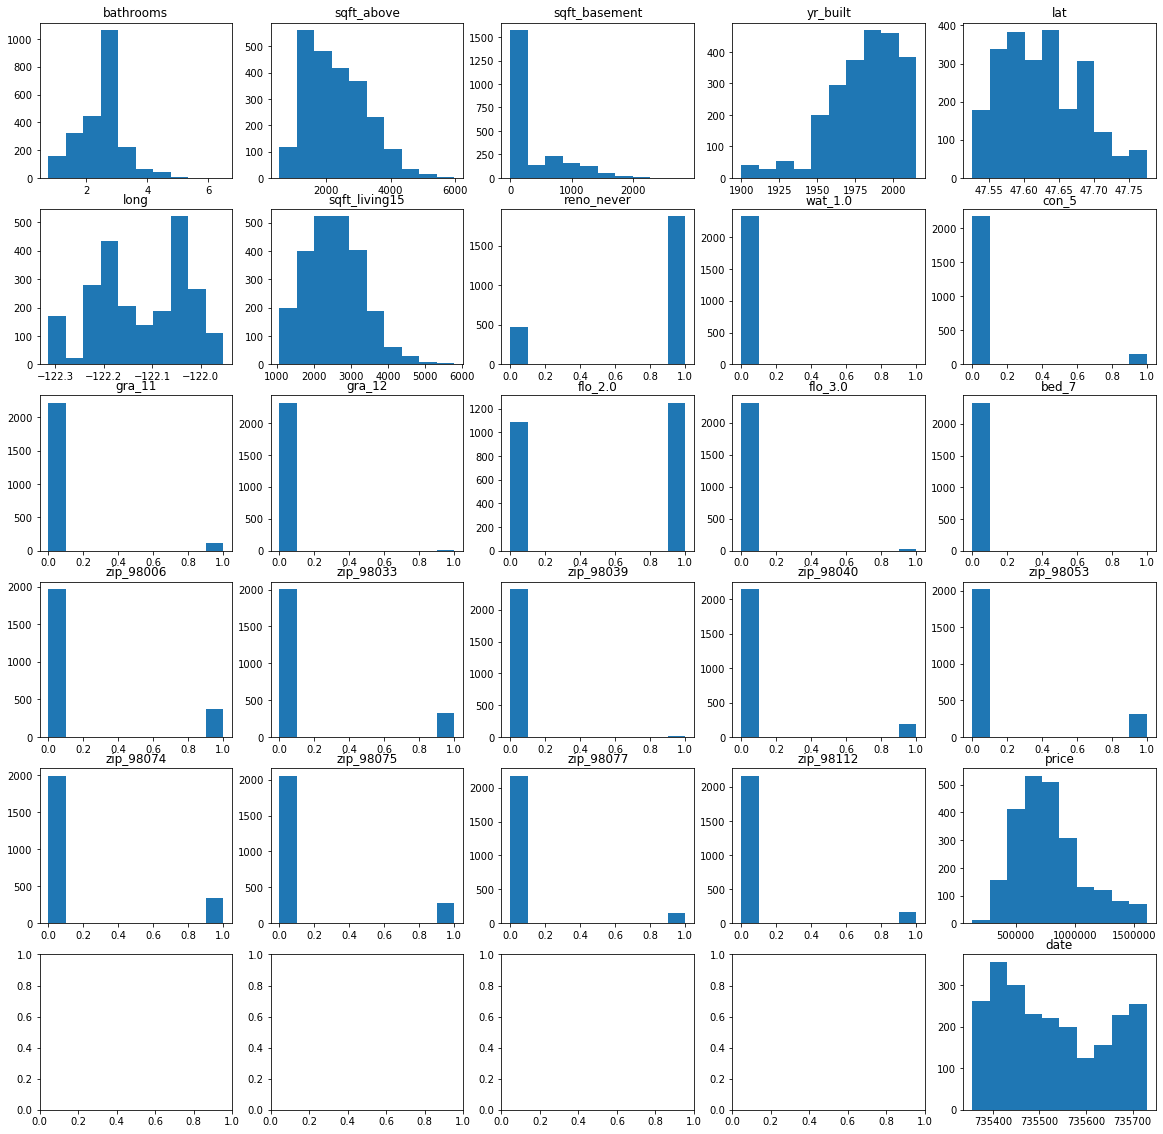

In [111]:
fig, axes = plt.subplots(nrows=6, ncols=5,figsize=(20,20))
plt.title('Graphs')
x = train4_df.price
for n in range(len(train4_df.columns)):
    row=(n-1)//5
    col=n%5-1
    ax=axes[row][col]
    y=train4_df.iloc[:,n]
    ax.hist(y)
    ax.set_title(train4_df.columns.values[n])
plt.show()   

In [113]:
trained5 = trained4.drop(columns = ["sqft_basement", "long"])
test5 = test4.drop(columns =  ["sqft_basement", "long"])

In [114]:
trained5_cont = trained5[["bathrooms", "sqft_above", "yr_built", "lat", "sqft_living15", "date"]]

In [115]:
test5_cont = test5[["bathrooms", "sqft_above", "yr_built", "lat", "sqft_living15", "date"]]

In [117]:
log_names_train = [f'{column}_log' for column in trained5_cont.columns]
df_log_train = np.log(trained5_cont)
df_log_train.columns=log_names_train
df_log_train

,bathrooms_log,sqft_above_log,yr_built_log,lat_log,sqft_living15_log,date_log
3734,0.916291,7.640123,7.598900,3.864367,7.640123,13.508608
3253,1.321756,7.986165,7.565275,3.863652,7.757906,13.508599
16826,0.223144,6.956545,7.605392,3.863238,7.003065,13.508277
5106,0.810930,7.649693,7.592366,3.863820,7.625595,13.508268
8767,0.810930,7.200425,7.583248,3.862234,7.757906,13.508474
...,...,...,...,...,...,...
20113,0.916291,7.855545,7.607381,3.864621,7.506592,13.508162
6271,0.559616,7.554859,7.588830,3.863412,7.855545,13.508294
7679,0.810930,7.682482,7.594381,3.863610,7.522941,13.508170
1611,0.916291,7.843849,7.603399,3.862681,7.843849,13.508117


In [118]:
log_names_test = [f'{column}_log' for column in test5_cont.columns]
df_log_test = np.log(test5_cont)
df_log_test.columns=log_names_test
df_log_test

,bathrooms_log,sqft_above_log,yr_built_log,lat_log,sqft_living15_log,date_log
3211,0.693147,7.420579,7.580189,3.864097,7.700748,13.508371
15378,0.000000,7.265430,7.577634,3.862244,7.265430,13.508449
12183,0.916291,8.016318,7.600402,3.862990,7.933797,13.508114
2042,1.098612,7.908387,7.579168,3.862482,7.878534,13.508294
4710,0.916291,7.177782,7.580700,3.864690,7.625595,13.508401
...,...,...,...,...,...,...
5048,0.559616,7.539027,7.589842,3.862650,7.912057,13.508515
11053,0.559616,7.390181,7.591357,3.861763,7.969012,13.508173
11754,0.693147,7.358831,7.603898,3.865120,7.680176,13.508200
16615,0.810930,7.969012,7.589336,3.863452,7.851661,13.508133


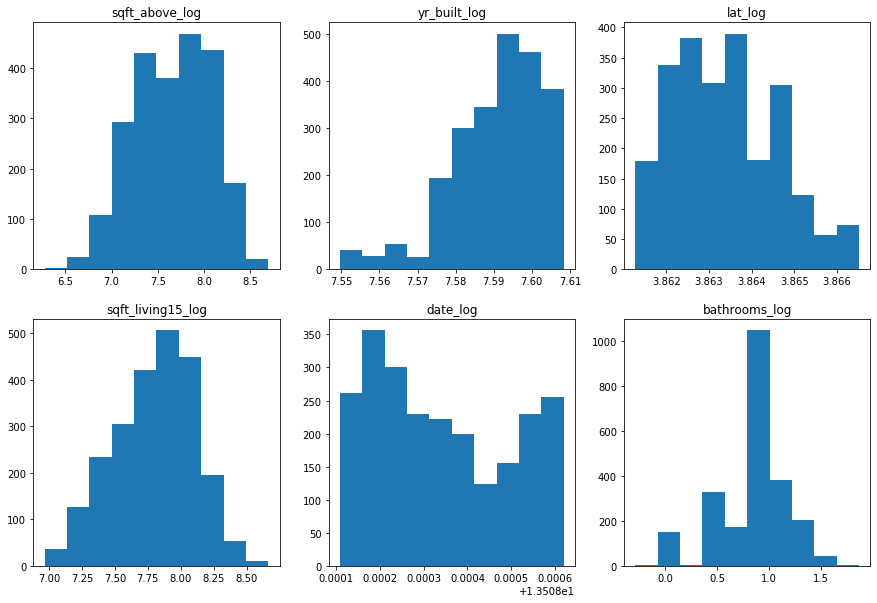

In [121]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15,10))
plt.title('Graphs')
for n in range(len(df_log_train.columns)):
    row=(n-1)//3
    col=n%3-1
    ax=axes[row][col]
    y=df_log_train.iloc[:,n]
    ax.hist(y)
    ax.set_title(df_log_train.columns.values[n])
plt.show()   

In [122]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()
df_log_norm = df_log_train.apply(normalize)
df_log_norm

,bathrooms_log,sqft_above_log,yr_built_log,lat_log,sqft_living15_log,date_log
3734,0.240959,-0.043985,0.655176,0.790080,-0.533414,1.725808
3253,1.501413,0.793429,-2.181100,0.198342,-0.146858,1.672796
16826,-1.913802,-1.698230,1.202766,-0.143705,-2.624195,-0.421533
5106,-0.086571,-0.020827,0.104007,0.337204,-0.581095,-0.483401
8767,-0.086571,-1.108046,-0.665145,-0.974235,-0.146858,0.859888
...,...,...,...,...,...,...
20113,0.240959,0.477331,1.370543,0.999949,-0.971655,-1.172828
6271,-0.867823,-0.250324,-0.194275,0.000424,0.173585,-0.315475
7679,-0.086571,0.058524,0.273981,0.163623,-0.917999,-1.119792
1611,0.240959,0.449027,1.034655,-0.604042,0.135199,-1.464530


In [123]:
df_log_norm_test = df_log_test.apply(normalize)
df_log_norm_test

,bathrooms_log,sqft_above_log,yr_built_log,lat_log,sqft_living15_log,date_log
3211,-0.453223,-0.515743,-0.804380,0.617846,-0.303155,0.135493
15378,-2.654390,-0.889705,-1.008670,-0.958717,-1.767041,0.636605
12183,0.255394,0.920186,0.811418,-0.323808,0.480542,-1.526368
2042,0.834377,0.660037,-0.886033,-0.756568,0.294705,-0.365658
4710,0.255394,-1.100964,-0.763584,1.123086,-0.555878,0.328910
...,...,...,...,...,...,...
5048,-0.877267,-0.230244,-0.032802,-0.613483,0.407435,1.067355
11053,-0.877267,-0.589012,0.088348,-1.368530,0.598963,-1.148235
11754,-0.453223,-0.664577,1.090855,1.488886,-0.372335,-0.972367
16615,-0.079190,0.806163,-0.073226,0.069419,0.204337,-1.403252


In [125]:
trained5_log = pd.concat([df_log_norm, trained5.drop(columns = ["bathrooms", "sqft_above", "yr_built", "lat", "sqft_living15", "date"])], axis =1)

In [126]:
trained5_log

,bathrooms_log,sqft_above_log,yr_built_log,lat_log,sqft_living15_log,date_log,reno_never,wat_1.0,con_5,gra_11,...,bed_7,zip_98006,zip_98033,zip_98039,zip_98040,zip_98053,zip_98074,zip_98075,zip_98077,zip_98112
3734,0.240959,-0.043985,0.655176,0.790080,-0.533414,1.725808,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3253,1.501413,0.793429,-2.181100,0.198342,-0.146858,1.672796,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16826,-1.913802,-1.698230,1.202766,-0.143705,-2.624195,-0.421533,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5106,-0.086571,-0.020827,0.104007,0.337204,-0.581095,-0.483401,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8767,-0.086571,-1.108046,-0.665145,-0.974235,-0.146858,0.859888,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20113,0.240959,0.477331,1.370543,0.999949,-0.971655,-1.172828,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6271,-0.867823,-0.250324,-0.194275,0.000424,0.173585,-0.315475,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7679,-0.086571,0.058524,0.273981,0.163623,-0.917999,-1.119792,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1611,0.240959,0.449027,1.034655,-0.604042,0.135199,-1.464530,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [128]:
test5_log = pd.concat([df_log_norm_test, test5.drop(columns = ["bathrooms", "sqft_above", "yr_built", "lat", "sqft_living15", "date"])], axis =1)

In [129]:
test5_log

,bathrooms_log,sqft_above_log,yr_built_log,lat_log,sqft_living15_log,date_log,reno_never,wat_1.0,con_5,gra_11,...,bed_7,zip_98006,zip_98033,zip_98039,zip_98040,zip_98053,zip_98074,zip_98075,zip_98077,zip_98112
3211,-0.453223,-0.515743,-0.804380,0.617846,-0.303155,0.135493,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
15378,-2.654390,-0.889705,-1.008670,-0.958717,-1.767041,0.636605,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
12183,0.255394,0.920186,0.811418,-0.323808,0.480542,-1.526368,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2042,0.834377,0.660037,-0.886033,-0.756568,0.294705,-0.365658,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4710,0.255394,-1.100964,-0.763584,1.123086,-0.555878,0.328910,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5048,-0.877267,-0.230244,-0.032802,-0.613483,0.407435,1.067355,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11053,-0.877267,-0.589012,0.088348,-1.368530,0.598963,-1.148235,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11754,-0.453223,-0.664577,1.090855,1.488886,-0.372335,-0.972367,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
16615,-0.079190,0.806163,-0.073226,0.069419,0.204337,-1.403252,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [130]:
X_int_5 = sm.add_constant(trained5_log)
model5 = sm.OLS(y_train, X_int_5).fit()
summary5 = model5.summary()
summary5

C:\Users\swzoe\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     265.2
Date:                Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:14:43   Log-Likelihood:                -31119.
No. Observations:                2334   AIC:                         6.229e+04
Df Residuals:                    2310   BIC:                         6.242e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.137e+06    1.4e+04     81.409      0.000    1.11e+06    1.16e+06
bathrooms_log      4.729e+04   4572.730     10.343      0.000    3.83e+04    5.63e+04
sqft_above_log     1.284e+05   5895.630     21.773      0.000    1.17e+05     1.4e+05
yr_built_log       1.866e+04   4976.667      3.749      0.000    8899.227    2.84e+04
lat_log            2.708e+04   1.15e+04      2.349      0.019    4473.441    4.97e+04
sqft_living15_log  7.418e+04   4696.768     15.793      0.000     6.5e+04    8.34e+04
date_log           1.441e+04   3121.325      4.616      0.000    8288.648    2.05e+04
reno_never          -2.2e+04   7846.741     -2.804      0.005   -3.74e+04   -6613.836
wat_1.0            5.442e+05    6.3e+04      8.639      0.000    4.21e+05    6.68e+05
con_5              7.324e+04   1.32e+04      5.556      0.000    4.74e+04    9.91e+04
gra_11             1.694e+05   1.53e+04     11.049      0.000    1.39e+05       2e+05
gra_12             2.497e+05   3.75e+04      6.651      0.000    1.76e+05    3.23e+05
flo_2.0           -8.772e+04   9084.589     -9.656      0.000   -1.06e+05   -6.99e+04
flo_3.0            -1.33e+05   3.68e+04     -3.619      0.000   -2.05e+05    -6.1e+04
bed_7             -4.694e+05   1.52e+05     -3.096      0.002   -7.67e+05   -1.72e+05
zip_98006         -2.981e+05   1.78e+04    -16.770      0.000   -3.33e+05   -2.63e+05
zip_98033          -2.86e+05   1.92e+04    -14.899      0.000   -3.24e+05   -2.48e+05
zip_98039          1.574e+05   4.68e+04      3.363      0.001    6.56e+04    2.49e+05
zip_98040         -9.958e+04   1.89e+04     -5.270      0.000   -1.37e+05   -6.25e+04
zip_98053         -4.663e+05   2.01e+04    -23.237      0.000   -5.06e+05   -4.27e+05
zip_98074         -4.371e+05   1.46e+04    -29.866      0.000   -4.66e+05   -4.08e+05
zip_98075         -4.259e+05    1.6e+04    -26.619      0.000   -4.57e+05   -3.94e+05
zip_98077         -5.373e+05   3.16e+04    -16.988      0.000   -5.99e+05   -4.75e+05
zip_98112         -1.567e+04   1.75e+04     -0.896      0.370      -5e+04    1.86e+04
==============================================================================
Omnibus:                      268.739   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              588.265
Skew:                           0.694   Prob(JB):                    1.82e-128
Kurtosis:                       5.030   Cond. No.                         81.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
y_hat5 = model5.predict()
y_hat5

array([ 788120.19620667, 1200204.66323242,  521120.6010756 , ...,
        519049.74640871,  662504.49196592,  979514.07088429])

In [133]:
train_rmse5 = mean_squared_error(y_train ,y_hat5)**.5
train_rmse5

149312.82043313526

We will now try log transforming the dependent variable to make it more normal and of the same magnitude of the other variables.

In [142]:
yt_log = np.log(y_train)
y_train_log = normalize(yt_log)

In [143]:
model6 = sm.OLS(y_train_log, X_int_5).fit()
summary6 = model6.summary()
summary6

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     317.8
Date:                Wed, 18 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:36:56   Log-Likelihood:                -1646.4
No. Observations:                2334   AIC:                             3341.
Df Residuals:                    2310   BIC:                             3479.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.2158      0.046     26.526      0.000       1.126       1.306
bathrooms_log         0.1817      0.015     12.109      0.000       0.152       0.211
sqft_above_log        0.4732      0.019     24.462      0.000       0.435       0.511
yr_built_log          0.0582      0.016      3.566      0.000       0.026       0.090
lat_log               0.0953      0.038      2.521      0.012       0.021       0.170
sqft_living15_log     0.3041      0.015     19.730      0.000       0.274       0.334
date_log              0.0494      0.010      4.828      0.000       0.029       0.070
reno_never           -0.0616      0.026     -2.393      0.017      -0.112      -0.011
wat_1.0               1.6709      0.207      8.085      0.000       1.266       2.076
con_5                 0.2663      0.043      6.157      0.000       0.181       0.351
gra_11                0.3278      0.050      6.514      0.000       0.229       0.426
gra_12                0.3276      0.123      2.659      0.008       0.086       0.569
flo_2.0              -0.2990      0.030    -10.032      0.000      -0.357      -0.241
flo_3.0              -0.3647      0.121     -3.024      0.003      -0.601      -0.128
bed_7                -1.5559      0.497     -3.128      0.002      -2.531      -0.580
zip_98006            -0.9977      0.058    -17.106      0.000      -1.112      -0.883
zip_98033            -0.9591      0.063    -15.226      0.000      -1.083      -0.836
zip_98039             0.3823      0.154      2.490      0.013       0.081       0.684
zip_98040            -0.3414      0.062     -5.506      0.000      -0.463      -0.220
zip_98053            -1.6181      0.066    -24.577      0.000      -1.747      -1.489
zip_98074            -1.4768      0.048    -30.750      0.000      -1.571      -1.383
zip_98075            -1.3971      0.052    -26.615      0.000      -1.500      -1.294
zip_98077            -1.8736      0.104    -18.054      0.000      -2.077      -1.670
zip_98112            -0.0276      0.057     -0.480      0.631      -0.140       0.085
==============================================================================
Omnibus:                      241.571   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1216.358
Skew:                          -0.361   Prob(JB):                    7.44e-265
Kurtosis:                       6.462   Cond. No.                         81.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
yhat6_log = model6.predict()
yhat6 = np.exp((yhat6_log * yt_log.std())+ yt_log.mean())
yhat6

array([ 734655.66939391, 1260705.42785062,  490856.92921768, ...,
        522988.16764909,  650802.50690274,  976459.27595863])

In [153]:
train_rmse6 = mean_squared_error(y_train ,yhat6)**.5
train_rmse6

145386.18040631321

In [158]:
yhat6_log = model6.predict()
train_rmse6 = mean_squared_error(y_train_log ,yhat6_log)**.5
train_rmse6

0.48990680450268004

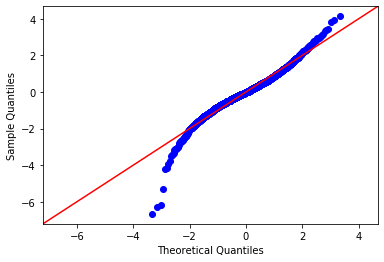

In [154]:
fig = sm.graphics.qqplot(model6.resid, dist=stats.norm, line='45', fit=True)

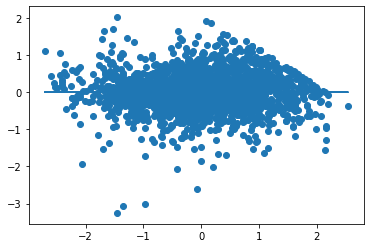

In [156]:
plt.scatter(model6.predict(X_int_5), model6.resid)
plt.plot(model6.predict(X_int_5), [0 for i in range(len(X_int_5))]);